###  Check GPU on Apex Server

In [9]:
!nvidia-smi

/bin/bash: /home/dip_33/miniconda3/envs/ml-jupyter/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Oct 22 18:35:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB           On | 00000000:87:00.0 Off |                    0 |
| N/A   30C    P0               60W / 400W|   1131MiB / 40960MiB |      0%      Default |
|                              

# Check Where env python run Should run in conda ml-jupyter

In [10]:
!which python

/bin/bash: /home/dip_33/miniconda3/envs/ml-jupyter/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/dip_33/miniconda3/envs/ml-jupyter/bin/python


### Install Libary in this project.

In [ ]:
%pip install supervision==0.3.0
%pip install pytorch==1.13.1
%pip install torchvision==0.14.1
%pip install torchaudio==0.13.1
%pip install pytorch-cuda==11.7
%pip install transformers==4.31.0
%pip install pytorch-lightning==2.0.5
%pip install timm
%pip install cython
%pip install pycocotools
%pip install scipy
%pip install tensorboard
%pip install roboflow
%pip install pandas
%pip install ipywidgets
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


In [90]:
#List all Libary in Conda Environment
!conda list

/bin/bash: /home/dip_33/miniconda3/envs/ml-jupyter/lib/libtinfo.so.6: no version information available (required by /bin/bash)
# packages in environment at /home/dip_33/miniconda3/envs/ml-jupyter:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
absl-py                   2.0.0                    pypi_0    pypi
aiohttp                   3.8.6                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
anyio                     4.0.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hb9d737c_2    conda-forge
asttokens                 2.4.0              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
async-timeout             4.0.3                    

### Check if Pytorch see gpu and check all Libary version.

In [29]:
import torch
print(f'##############################\n{torch.__version__}\n##############################\n')

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # 0 indicates the first GPU
    print(f"Current GPU: {current_gpu}")

    # Switch to the GPU (if not already)
    device = torch.device("cuda")
    print(f"Using GPU: {current_gpu}")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")


##############################
1.13.1+cu117
##############################

Number of available GPUs: 1
Current GPU: NVIDIA A100-SXM4-40GB
Using GPU: NVIDIA A100-SXM4-40GB


In [5]:
import supervision
import transformers

supervision.__version__ , transformers.__version__

('0.3.0', '4.31.0')

In [5]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.0.5


Load Dataset and setup dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="v6wanvB3hqfanMKcyxdL")
project = rf.workspace("5060tanapoowapat-yumsarn").project("fruit_detection-ixhw3")
dataset = project.version(1).download("coco")


In [6]:
#Check Dataset if it is downloaded.
%ls

/bin/bash: /home/dip_33/miniconda3/envs/ml-jupyter/lib/libtinfo.so.6: no version information available (required by /bin/bash)
err_65067.txt           Fruit_detection-1/  out_65067.txt
example-run-jupyter.sh  lightning_logs/


In [30]:
import os
import torchvision
#LOAD DATASET

print(os.getcwd())

dataset = '/home/dip_33/jupyter-workspace/Fruit_detection-1'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

# Check folder that exit or not.
if not os.path.exists(TRAIN_DIRECTORY):
    print(f"Training directory '{TRAIN_DIRECTORY}' does not exist.")
else:
    print(f"Training directory exists: {TRAIN_DIRECTORY}")

if not os.path.exists(VAL_DIRECTORY):
    print(f"Validation directory '{VAL_DIRECTORY}' does not exist.")
else:
    print(f"Validation directory exists: {VAL_DIRECTORY}")

if not os.path.exists(TEST_DIRECTORY):
    print(f"Test directory '{TEST_DIRECTORY}' does not exist.")
else:
    print(f"Test directory exists: {TEST_DIRECTORY}")

/home/dip_33/jupyter-workspace
Training directory exists: /home/dip_33/jupyter-workspace/Fruit_detection-1/train
Validation directory exists: /home/dip_33/jupyter-workspace/Fruit_detection-1/valid
Test directory exists: /home/dip_33/jupyter-workspace/Fruit_detection-1/test


### SETUP LIBARY

In [12]:
import torchvision
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import DetrImageProcessor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch
from pytorch_lightning import Trainer
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv
from sklearn.metrics import confusion_matrix, classification_report


### SETPU DATASET LOADER

In [31]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json" if train else "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [32]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder=TRAIN_DIRECTORY, processor=processor)
val_dataset = CocoDetection(img_folder=VAL_DIRECTORY, processor=processor, train=False)
test_dataset = CocoDetection(img_folder=TEST_DIRECTORY, processor=processor, train=False)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [33]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print('Number of test examples:', len(test_dataset))

Number of training examples: 630
Number of validation examples: 60
Number of test examples: 30


Image n°462


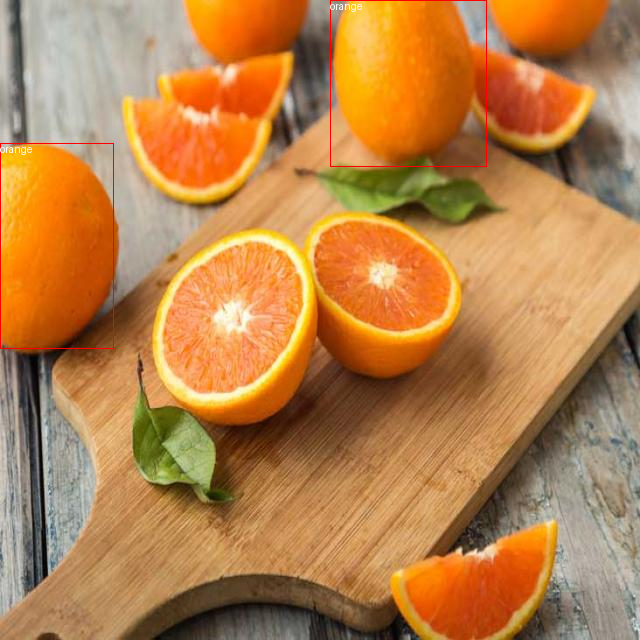

In [34]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/home/dip_33/jupyter-workspace/Fruit_detection-1/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [35]:
def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
test_dataloader = DataLoader(dataset=test_dataset, collate_fn=collate_fn, batch_size=4)
batch = next(iter(train_dataloader))

In [36]:
batch.keys()


dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [37]:
pixel_values, target = train_dataset[0]

In [38]:
pixel_values.shape

torch.Size([3, 800, 800])

In [39]:
print(target)


{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([1, 1, 1, 1, 1]), 'boxes': tensor([[0.6359, 0.1828, 0.3719, 0.3656],
        [0.6438, 0.5906, 0.3313, 0.4094],
        [0.3461, 0.5742, 0.4016, 0.4453],
        [0.5750, 0.8109, 0.3250, 0.3688],
        [0.8336, 0.7063, 0.3328, 0.3875]]), 'area': tensor([ 87018.7500,  86787.5000, 114445.3125,  76700.0000,  82537.5000]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'orig_size': tensor([640, 640])}


### Start Train

In [40]:
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [41]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
batch = next(iter(train_dataloader))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/
     

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 4122093), started 1 day, 0:55:34 ago. (Use '!kill 4122093' to kill it.)

In [43]:
outputs.logits.shape

torch.Size([4, 100, 5])

In [44]:
# settings
MAX_EPOCHS = 10

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1)

trainer.fit(model)

/home/dip_33/miniconda3/envs/ml-jupyter/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dip_33/miniconda3/envs/ml-jupyter/lib/python3. ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
----

Sanity Checking: 0it [00:00, ?it/s]

/home/dip_33/miniconda3/envs/ml-jupyter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dip_33/miniconda3/envs/ml-jupyter/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/dip_33/miniconda3/envs/ml-jupyter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### SAVE MODEL

In [45]:
!huggingface-cli login --token <Your Token>

/bin/bash: /home/dip_33/miniconda3/envs/ml-jupyter/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/dip_33/.cache/huggingface/token
Login successful


In [47]:
model.model.push_to_hub("Komet/my-fruit-detection-3")
processor.push_to_hub("Komet/my-fruit-detection-3")

KeyboardInterrupt: 

### Load Test Image

In [24]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("Komet/my-fruit-detection-3", ignore_mismatched_sizes=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained("Komet/my-fruit-detection-3", ignore_mismatched_sizes=True)

### Test Model

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = test_dataset[1]

In [117]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)


torch.Size([1, 3, 800, 800])


In [119]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [120]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/30 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [121]:
#We can use the image_id in target to know which image it is
pixel_values, target = test_dataset[1]

In [122]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 800])


In [123]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [20]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):

    # Define the label-to-class mapping
    label2class = {
        1: "apple",
        2: "banana",
        3: "orange"
    }
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        class_name = label2class.get(label, f'Class {label}')
        print(class_name)
        text = f'{class_name}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

apple
orange
banana


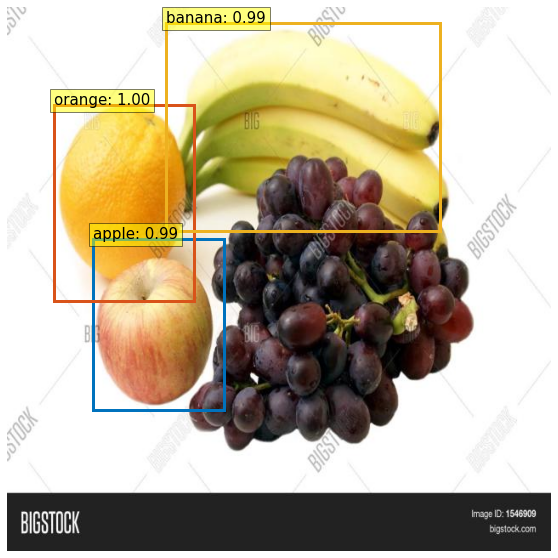

In [144]:
# load image based on ID
image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('Fruit_detection-1/test/', image['file_name']))


# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.8)

results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])                                                                

### TEST with other test image.


banana
orange
apple


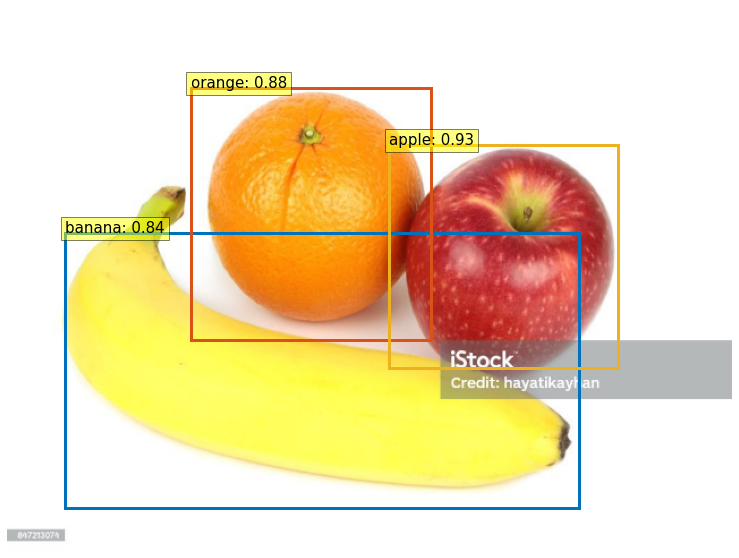

In [26]:
import cv2

# Define the path to the image you want to test
image_path = "2.jpg"  # Replace with the actual path to your test image

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (640, 480))
# Annotate detections
with torch.no_grad():
    # Load image and predict
    inputs = processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # Post-process
    width, height = 640, 480
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.8)
    
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])    